# Dynamics of Politicians

The model that we discussed in this post and the previous one is a pretty basic dynamic programming problem. In the context of econ, the framework of being elected vs. not elected is pretty similar to the job search question. Just as a brief recap, the idea of dynamic programming is to take a difficult multi-step problem and break them down into sequence of similar decision steps over time. 

In the politician problem that we have been discussing, the key is to identify how to break down this complicated issue of what decisions a politican makes and I've settled on primarily focussing on channels of affecting the election outcome probabilities. 

Before we dive into the code, I think it's best to do a brief recap of the model and the question. For an in-depth look, refer to my last post [here](https://pranay-gundam.github.io/blog/2024/dynamics-of-politicians/). Basically, we are modeling the life-cycle of a politician through a job search model. These politican's form utility over both how much of the consumption good they consume and also how they vote when they have been elected into office. Their actions consist of choosing how much to spend on the next election, how much to consume (the leftover money is saved), and how they should vote if they are currently elected in.

In [71]:
# Load in some helpful packages
import numpy as np
import matplotlib.pyplot as plt
import warnings

The cell below is probably the most important one when it comes to making something interesting. Doing the value iteration solving itself is not all that exciting once you know how to do it and have done it many times before, but the value and relative values of the parameters below is what drives the insights we can make. There are many choices to make: what should the moral compasses look like for each the politician, constituency, and political party, what are the relative importance of consumption and voting in forming utility or elections spendings and voting in the transition probabilities, what functions/distributions should we use for the utility and transition probabilities. In an unestimated model, each of of these decisions have a significant impact on what comes out of the model.

In [72]:
# Initialize model parameters
political_spectrum_size    = 2
constituency_moral_compass = np.array([0.6, 0.6])
party_moral_compass        = np.ones(political_spectrum_size)
init_moral_compass         = np.ones(political_spectrum_size)

# Utility weights, these determine how important a politician's morality is relative to consuming money 
phi_c = 10.0
phi_v = 5.0

# temporal discount factor
beta = 0.3

# voted-in wage, utility function, and transition probability distribution
w_i               = 25
u_i               = lambda c,v: phi_c * np.log(c) + phi_v * np.exp(-np.linalg.norm(v - init_moral_compass))
draw_transition_i = lambda spend: np.random.beta(a = spend, b = 7.5)

# voted-out wage, utility function, and transition probability distribution
w_o = 1
u_o = lambda c: phi_c * np.log(c)
draw_transition_o = lambda spend: np.random.beta(a = spend, b = 7.5)

One thing that I can already tell will be an issue is the size of the policy space. The statespace itself is not too bad, it's just the savings and whether or not a politician is voted in, but the policy space includes spendings on consumption and the election both of which are integer values in addition to the specific vote that a voted in politician can make. The one fact though that these numbers have to sum up to less than the total money a politician is faced with though does decrease the size of the space a bit. Another issue that I see is that value iteration neccesitates that I put a cap on the maximum savings but certain parameter values may incentivize higher levels of savings. I need to also discretize the policy action as well.

Given how long the iterations are taking, I may just reduce the statespace to not include any savings.

In [73]:
# Helper functions
def policy_out_options(savings):
    pol_list = []

    for save in range(savings+1):
        for cons in range(savings - save+1):
            pol_list.append((save, cons, savings - save - cons))

    return pol_list

def voted_in_value(sav, cons, elec_spend, v_iter_i, v_iter_o, vote = init_moral_compass):
    vote_prob = np.exp(-np.linalg.norm(vote - constituency_moral_compass))
    prob_votedin  = ((elec_spend + vote_prob) / (elec_spend + vote_prob + 10))
    prob_votedout = 1 - prob_votedin
    return u_i(cons, vote) + beta * (prob_votedin * v_iter_i[sav] + prob_votedout * v_iter_o[sav])

def voted_out_value(sav, cons, elec_spend, v_iter_i, v_iter_o):
    prob_votedin  = (elec_spend / (elec_spend + 10))
    prob_votedout = 1 - prob_votedin
    return u_o(cons) + beta * (prob_votedin * v_iter_i[sav] + prob_votedout * v_iter_o[sav])

The one detail of nuance here doing the iteration when the transition probability is dependent on the probability. My first guess would be to use the expected value of transition probability given the election spending. For a beta distribution, this is specificaly $\frac{\alpha}{\alpha + \beta}$ where in our case $\alpha$ is the amount spent by the politician on the election and $\beta$ is $7.5$. I still need to make choices on whether or not the voted in and voted out transition probability distributions are different.

Although, this specification where the transition probability is dependent on the politician's choice is indeed valid, I also remember doing something called Q-learning in previous machine learning classes to solve such specifications where we don't just use the expectation of the transition probability but sample them iteratively. 

In [74]:
warnings.filterwarnings('ignore')
# Initialize VF convergence requirements
max_iter = 100


# Initialize the state space (needs to be finite)
savings           = np.arange(0, 51, 1)

value_votedin = np.zeros((len(savings) + w_i))
value_votedout = np.zeros((len(savings) + w_i))

policy_votedin = np.zeros((len(savings)), dtype=object)
policy_votedout = np.zeros((len(savings)), dtype=object)

for iter in range(max_iter):
    for save in savings:
        policy_options_in = policy_out_options(save+w_i)
        policy_options_out = policy_out_options(save+w_o)
        
        values_in = [voted_in_value(sav, cons, elec_spend, value_votedin, value_votedout) for 
                                    sav, cons, elec_spend in policy_options_in]
        values_out = [voted_out_value(sav, cons, elec_spend, value_votedin, value_votedout) for 
                                      sav, cons, elec_spend in policy_options_out]
        
        value_votedin[save] = np.max(values_in)
        policy_votedin[save] = policy_options_in[np.argmax(values_in)]

        value_votedout[save] = np.max(values_out)
        policy_votedout[save] = policy_options_out[np.argmax(values_out)]

Now that the value iteration is over, let's look at a couple of results.

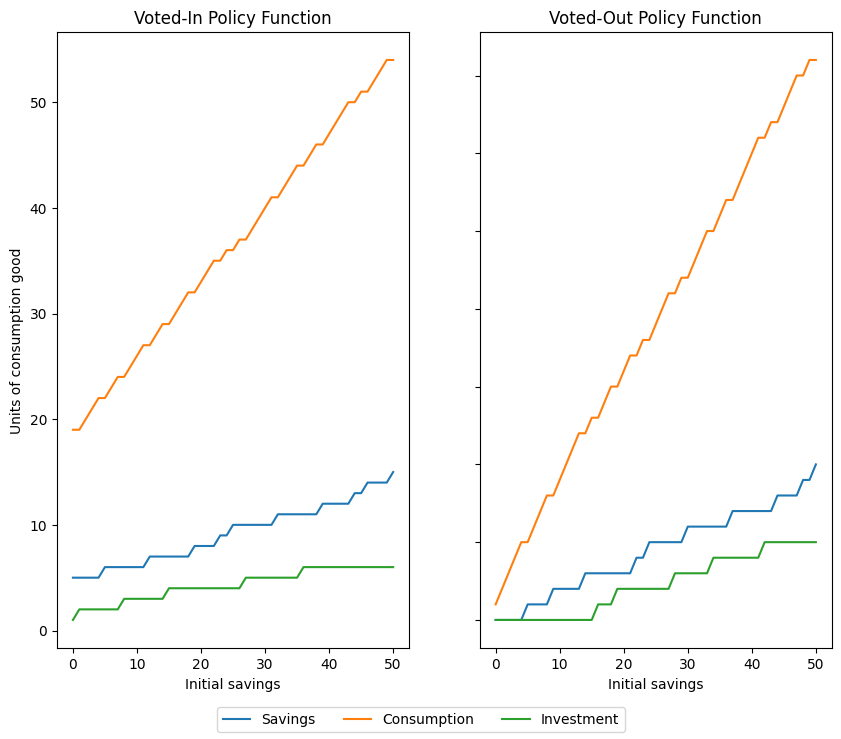

In [75]:
xs = savings
ys_save_VI = [policy_votedin[x][0] for x in xs]
ys_consume_VI = [policy_votedin[x][1] for x in xs]
ys_invest_VI = [policy_votedin[x][2] for x in xs]

ys_save_VO = [policy_votedout[x][0] for x in xs]
ys_consume_VO = [policy_votedout[x][1] for x in xs]
ys_invest_VO = [policy_votedout[x][2] for x in xs]

fig, axs = plt.subplots(1, 2, figsize=(10, 8))

# Create the plot with labels
axs[0].plot(xs, ys_save_VI, label='Savings')
axs[0].plot(xs, ys_consume_VI, label='Consumption')
axs[0].plot(xs, ys_invest_VI, label='Investment')

axs[1].plot(xs, ys_save_VO, label='Savings')
axs[1].plot(xs, ys_consume_VO, label='Consumption')
axs[1].plot(xs, ys_invest_VO, label='Investment')

# Add title and labels
for ax in axs.flat:
    ax.set(xlabel='Initial savings', ylabel='Units of consumption good')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

axs[0].set_title('Voted-In Policy Function')
axs[1].set_title('Voted-Out Policy Function')

# Add the legend
fig.legend(*axs[0].get_legend_handles_labels(), loc='lower center', ncol=3)

# Show the plot
plt.show()

Before I get into analyzing the graphs, I will say that I cooked up the values of parameters myself to get a specific behavior (as opposed to actually estimating them with data). 

There are a few behaviors that are interesting to look at here. First is the comparison between the voted-in and voted-out behaviors. The voted-in politician seems to be less concerned with 